# VISUALIZATION OF THE LOSS AND ACCURACY DURING TRAINING

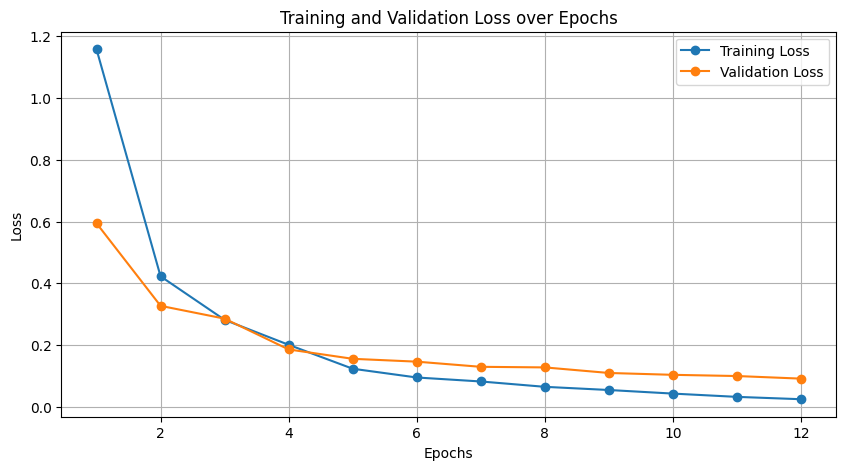

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Manual data for the training and validation loss extracted from images
data = {
    'Epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Training Loss': [1.1572, 0.4227, 0.2819, 0.2012, 0.1238, 0.0955, 0.0826, 0.0653, 0.0550, 0.0434, 0.0328, 0.0252],
    'Validation Loss': [0.5944, 0.3272, 0.2858, 0.1862, 0.1559, 0.1467, 0.1300, 0.1281, 0.1101, 0.1041, 0.1002, 0.0918]
}

df = pd.DataFrame(data)

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(df['Epochs'], df['Training Loss'], label='Training Loss', marker='o')
plt.plot(df['Epochs'], df['Validation Loss'], label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

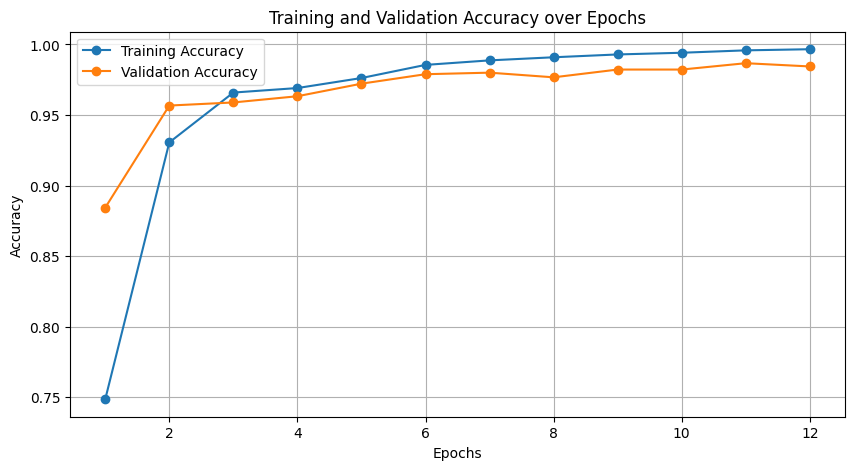

In [3]:
# Manual data for the training and validation accuracy extracted from images
data_accuracy = {
    'Epochs': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'Training Accuracy': [0.7487, 0.9306, 0.9659, 0.9691, 0.9762, 0.9855, 0.9887, 0.9909, 0.9929, 0.9941, 0.9958, 0.9966],
    'Validation Accuracy': [0.8844, 0.9567, 0.9589, 0.9633, 0.9722, 0.9789, 0.9800, 0.9767, 0.9822, 0.9822, 0.9867, 0.9844]
}

df_accuracy = pd.DataFrame(data_accuracy)

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(df_accuracy['Epochs'], df_accuracy['Training Accuracy'], label='Training Accuracy', marker='o')
plt.plot(df_accuracy['Epochs'], df_accuracy['Validation Accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# F1 SCORE

In [3]:
from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import BertTokenizerFast, TFBertForSequenceClassification, create_optimizer
from sklearn.preprocessing import LabelEncoder


def format_labels(labels):
        """
        Formats the labels by removing unwanted characters and spaces.

        Args:
            labels (list): A list of label strings.

        Returns:
            list: A list of formatted label strings.
        """
        labels = list(s.replace('"', '') for s in labels)
        labels = list(s.replace(' ', '') for s in labels)
        return labels

# Load the data
train_data = pd.read_csv('../data/train.csv', header=None)
test_data = pd.read_csv('../data/test.csv', header=None)
val_data = train_data.tail(900)
train_data = pd.read_csv('../data/train.csv', header=None, nrows=4078)

# Sentences
train_sentences = train_data[0].tolist()
val_sentences = val_data[0].tolist()
test_sentences = test_data[0].tolist()

# To string
train_sentences = [str(sentence) for sentence in train_sentences]  # Convert all elements to string if needed
val_sentences = [str(sentence) for sentence in val_sentences]  # Convert all elements to string if needed
test_sentences = [str(sentence) for sentence in test_sentences]  # Convert all elements to string if needed

# Labels
train_labels = format_labels(train_data[2].tolist())
val_labels = format_labels(val_data[2].tolist())
test_labels = format_labels(test_data[2].tolist())

values_to_remove = ['day_name','airfare+flight','flight+airline','flight_no+airline']

def remove_values_and_indices(values_to_remove, labels_list, sentence_list):
        """
        Removes specified values and their corresponding indices from labels and sequences.

        Args:
            values_to_remove (list): A list of label values to remove.
            labels_list (list): The list of labels.
            sentence_list (list): The list of the sequences.

        Returns:
            tuple: A tuple containing the cleaned labels list and the cleaned padded sequences array.
        """
        indices_to_remove = [idx for idx, item in enumerate(labels_list) if item in values_to_remove]
        cleaned_labels_list = [item for item in labels_list if item not in values_to_remove]
        cleaned_sentence_list = [item for idx, item in enumerate(sentence_list) if idx not in indices_to_remove]
        return cleaned_labels_list, cleaned_sentence_list

val_labels, val_sentences = remove_values_and_indices(values_to_remove, val_labels, val_sentences)
test_labels, test_sentences = remove_values_and_indices(values_to_remove, test_labels, test_sentences)

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)  # Fit on training labels

test_sentences = list(test_sentences)

# Transform labels
train_labels_encoded = label_encoder.transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)


# Ensure labels are numpy arrays of integer type
train_labels_encoded = np.array(train_labels_encoded, dtype='int32')
val_labels_encoded = np.array(val_labels_encoded, dtype='int32')
test_labels_encoded = np.array(test_labels_encoded, dtype='int32')

# Update num_classes
num_classes = len(label_encoder.classes_)

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize the data
train_encodings = tokenizer(
    train_sentences, truncation=True, padding=True, max_length=128
)

val_encodings = tokenizer(
    val_sentences, truncation=True, padding=True, max_length=128
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels_encoded
)).shuffle(len(train_sentences)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels_encoded
)).batch(32)

# Load the pre-trained model
model = TFBertForSequenceClassification.from_pretrained('MODEL.h5')

# Function to compute predictions and the F1-score (macro)
def evaluate_f1_score(dataset, true_labels):
    """
    Evaluates the model on a dataset and calculates the F1-score (macro).

    Args:
        dataset (tf.data.Dataset): The TensorFlow dataset.
        true_labels (np.array): The true labels for the dataset.

    Returns:
        float: The F1-score (macro) for the dataset.
    """
    # Perform predictions on the dataset
    preds = model.predict(dataset)
    
    # Convert logits to predicted class labels by taking the index of the max logit
    pred_labels = np.argmax(preds.logits, axis=1)
    
    # Calculate the F1-score with macro averaging
    f1_macro = f1_score(true_labels, pred_labels, average='macro')
    return f1_macro

# Evaluate F1-score on the validation set
val_f1_macro = evaluate_f1_score(val_dataset, val_labels_encoded)
print(f"F1-Score Macro on Validation Set: {val_f1_macro:.4f}")

Some layers from the model checkpoint at MODEL.h5 were not used when initializing TFBertForSequenceClassification: ['dropout_265']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at MODEL.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


29/29 [==============================] - 20s 661ms/step
F1-Score Macro on Validation Set: 0.8685
